# 10x Weight Loss Data

### Dataset Description

Milk diet over 6 weeks

Vitamins including Vitamin B

One patient has diabetes

Some immune cells are enriched for (1 = Myeloid), (2 = iNKTs & NK), (3 = GD & MAITs), (4 = T & B Cells)

All female


### Loading in the Data and Preprocessing

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
from matplotlib.pyplot import rc_context

In [2]:
patient_folders = ['D19-7142','D19-7143','D19-7144','D19-7145','D19-7146','D19-7147',
                   'D19-7148','D19-7149','D19-7150','D19-7151','D19-7152','D19-7153']

In [3]:
def read_Novo_data(in_data_folder, in_patient_folders, current_adata = None): #defining the function
    Processed_one = False #checkpoint
    for folder_name in in_patient_folders:
            my_file_path = os.path.join(in_data_folder, folder_name, 'filtered_feature_bc_matrix')
        
            if (current_adata is None) & (Processed_one == False):
                #print('got_here')
                current_adata = sc.read_10x_mtx(my_file_path, var_names = 'gene_symbols', cache = True)
                current_adata.obs['Folder'] = folder_name
                current_adata.obs['barcode'] = current_adata.obs.Folder + '_' + current_adata.obs.index
                Processed_one == False
            else:
                new_data = sc.read_10x_mtx(my_file_path, var_names = 'gene_symbols', cache = True)
                new_data.obs['Folder'] = folder_name
                new_data.obs['barcode'] = new_data.obs.Folder + '_' + new_data.obs.index    
                current_adata = current_adata.concatenate(new_data, join = 'outer')
            
            #current_data.obs.drop('batch', axis = 1, inplace = True)
    
    return current_adata

In [4]:
adata = read_Novo_data(in_data_folder = 'C:\\Users\\crtuser\\Documents\\PhD\\Project\\Data\\WL_PATIENT_10X_Human', 
                       in_patient_folders = patient_folders, current_adata = None)

In [5]:
adata.obs['Folder'].value_counts()

D19-7151    15285
D19-7153    14275
D19-7152    12955
D19-7144     9671
D19-7143     7822
D19-7145     7400
D19-7146     6774
D19-7147     4471
D19-7142     3846
D19-7150     3524
D19-7148     2788
D19-7149     2501
Name: Folder, dtype: int64

In [6]:
results_file = 'pbmc3k.h5ad'  # the file that will store the analysis results

In [7]:
adata

AnnData object with n_obs × n_vars = 91312 × 33538
    obs: 'Folder', 'barcode', 'batch'
    var: 'gene_ids', 'feature_types'

#### Show those genes that yield the highest fraction of counts in each single cell, across all cells

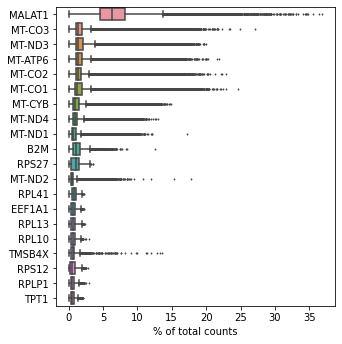

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

#### Filtering cells by genes present, filter genes by number of times present.

In [9]:
sc.pp.filter_cells(adata, min_genes=500) #Minimum number of genes expressed required for a cell to pass filtering
sc.pp.filter_genes(adata, min_cells=5) #Minimum number of cells expressed required for a gene to pass filtering.

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

- the number of genes expressed in the count matrix

- the total counts per cell

- the percentage of counts in mitochondrial gene

... storing 'Folder' as categorical
... storing 'feature_types' as categorical


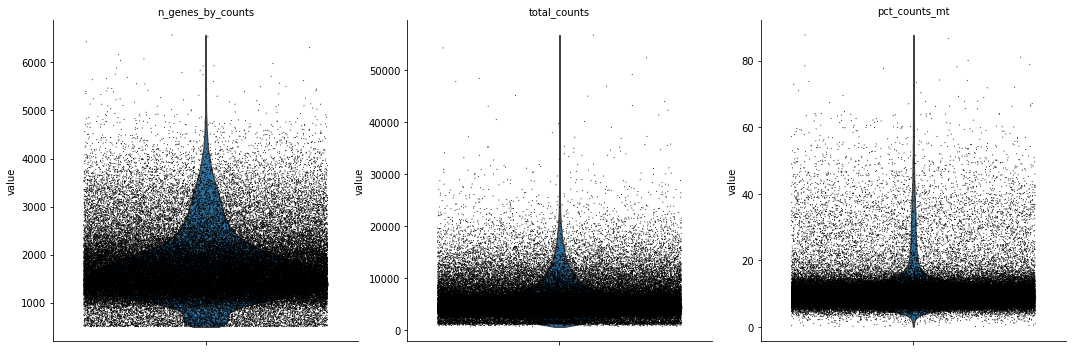

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

#### Removing cells with too many mitochondrial genes expressed

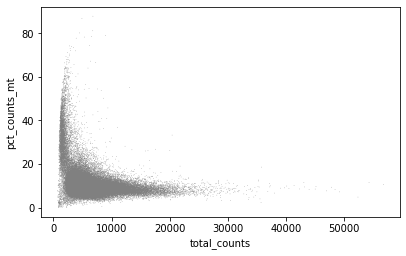

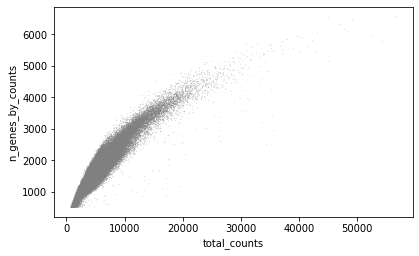

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.pct_counts_mt > 2, :]

#### Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)

C:\Users\crtuser\anaconda3\envs\scanpy\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


#### Logarithimise the Data

In [15]:
sc.pp.log1p(adata)

#### Identify highly-variable genes.

In [16]:
sc.pp.highly_variable_genes(adata,  n_top_genes = 3000)

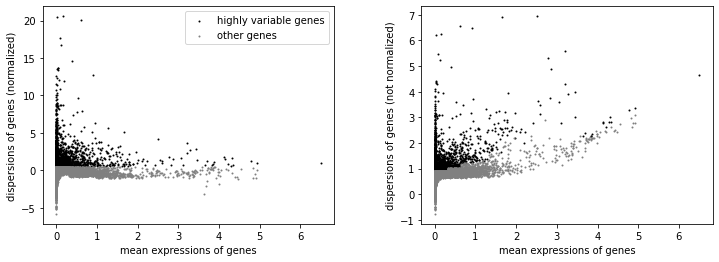

In [17]:
sc.pl.highly_variable_genes(adata)

#### Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [18]:
adata.raw = adata

#### Filtering

In [19]:
adata = adata[:, adata.var.highly_variable]

#### Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance

In [20]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

#### Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [21]:
sc.pp.scale(adata, max_value=10)

C:\Users\crtuser\anaconda3\envs\scanpy\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Principal component analysis

#### Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

# Batch correction
https://scanpy.readthedocs.io/en/stable/generated/scanpy.external.pp.harmony_integrate.html

In [23]:
sc.external.pp.harmony_integrate(adata, 'batch', basis='X_pca', adjusted_basis='X_pca_harmony')

2022-03-02 10:34:49,391 - harmonypy - INFO - Iteration 1 of 10
2022-03-02 10:35:43,826 - harmonypy - INFO - Iteration 2 of 10
2022-03-02 10:36:40,840 - harmonypy - INFO - Iteration 3 of 10
2022-03-02 10:37:30,970 - harmonypy - INFO - Converged after 3 iterations


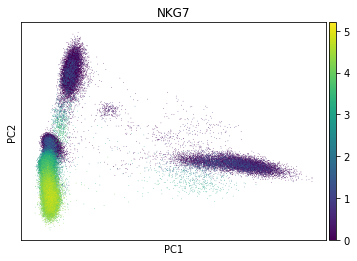

In [24]:
sc.pl.pca(adata, color='NKG7')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.

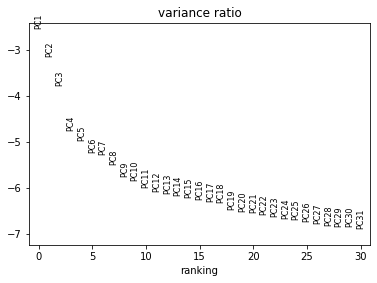

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
adata.write(results_file)

Compute the neighborhood graph of cells using the PCA representation of the data matrix

n_neighbors = The size of local neighborhood (in terms of number of neighboring data points) used for manifold approximation. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved.

#### Computing the Neighbourhood Graph

Needs to select new harmonised PCA as the PCA, otherwise it uses default.

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep= 'X_pca_harmony')

In [28]:
adata.obs

,Folder,barcode,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGAGAGGGC-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACCCAAGAGAGGGC-1,0,3589,3589,17245.0,1371.0,7.950130
AAACCCACAGATCCTA-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACCCACAGATCCTA-1,0,1550,1550,4944.0,495.0,10.012136
AAACGAACAAAGACGC-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACGAACAAAGACGC-1,0,1930,1930,6830.0,822.0,12.035139
AAACGAAGTGACATCT-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACGAAGTGACATCT-1,0,1888,1887,6741.0,649.0,9.627651
AAACGCTAGACTCAAA-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACGCTAGACTCAAA-1,0,2041,2041,7515.0,448.0,5.961411
...,...,...,...,...,...,...,...,...
TTTGTTGGTTCTCACC-1-1,D19-7153,D19-7153_TTTGTTGGTTCTCACC-1,1,1803,1803,6924.0,387.0,5.589255
TTTGTTGGTTGCATCA-1-1,D19-7153,D19-7153_TTTGTTGGTTGCATCA-1,1,1201,1201,3842.0,375.0,9.760542
TTTGTTGGTTTAGACC-1-1,D19-7153,D19-7153_TTTGTTGGTTTAGACC-1,1,1508,1508,4543.0,389.0,8.562624
TTTGTTGTCGATTGGT-1-1,D19-7153,D19-7153_TTTGTTGTCGATTGGT-1,1,2541,2541,9027.0,823.0,9.117093


#### Embedding the neighborhood graph

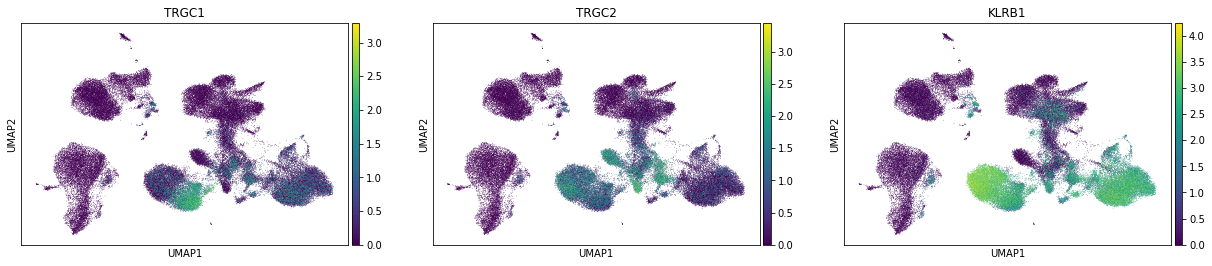

In [29]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['TRGC1','TRGC2',"KLRB1"])

In [30]:
adata.obsm['X_umap'].shape

(74122, 2)

In [31]:
adata.obsm['orig_PCA_umap'] = adata.obsm["X_umap"]
adata.obsm

AxisArrays with keys: X_pca, X_pca_harmony, X_umap, orig_PCA_umap

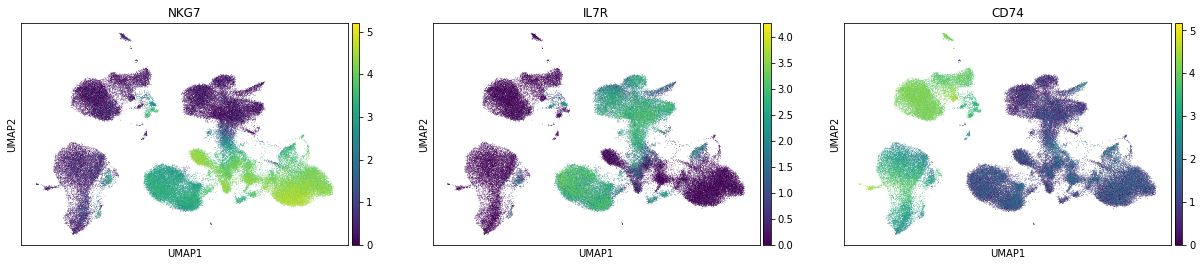

In [32]:
sc.pl.umap(adata, color=['NKG7', 'IL7R', 'CD74']) #scatter plot coloured by gene

### Clustering the Neighbourhood Graph

In [33]:
sc.tl.leiden(adata)

In [34]:
adata.obs

,Folder,barcode,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCCAAGAGAGGGC-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACCCAAGAGAGGGC-1,0,3589,3589,17245.0,1371.0,7.950130,9
AAACCCACAGATCCTA-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACCCACAGATCCTA-1,0,1550,1550,4944.0,495.0,10.012136,6
AAACGAACAAAGACGC-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACGAACAAAGACGC-1,0,1930,1930,6830.0,822.0,12.035139,3
AAACGAAGTGACATCT-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACGAAGTGACATCT-1,0,1888,1887,6741.0,649.0,9.627651,8
AAACGCTAGACTCAAA-1-0-0-0-0-0-0-0-0-0-0-0,D19-7142,D19-7142_AAACGCTAGACTCAAA-1,0,2041,2041,7515.0,448.0,5.961411,7
...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTCTCACC-1-1,D19-7153,D19-7153_TTTGTTGGTTCTCACC-1,1,1803,1803,6924.0,387.0,5.589255,2
TTTGTTGGTTGCATCA-1-1,D19-7153,D19-7153_TTTGTTGGTTGCATCA-1,1,1201,1201,3842.0,375.0,9.760542,2
TTTGTTGGTTTAGACC-1-1,D19-7153,D19-7153_TTTGTTGGTTTAGACC-1,1,1508,1508,4543.0,389.0,8.562624,5
TTTGTTGTCGATTGGT-1-1,D19-7153,D19-7153_TTTGTTGTCGATTGGT-1,1,2541,2541,9027.0,823.0,9.117093,9


#### Plot the Clusters

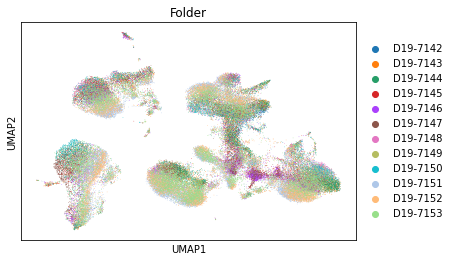

Trying to set attribute `._uns` of view, copying.


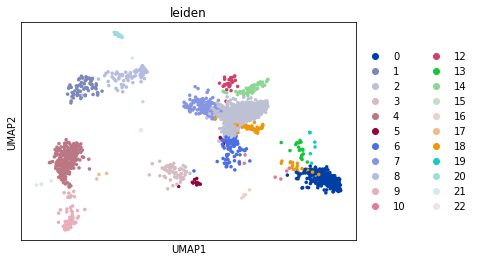

Trying to set attribute `._uns` of view, copying.


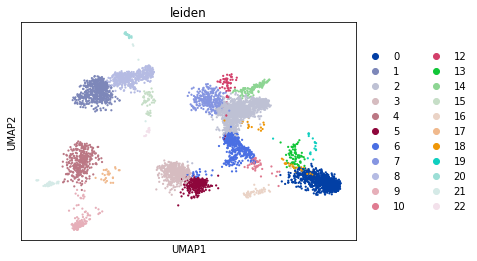

Trying to set attribute `._uns` of view, copying.


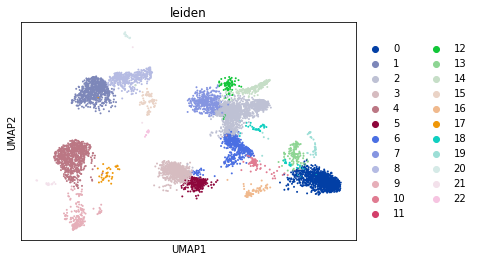

Trying to set attribute `._uns` of view, copying.


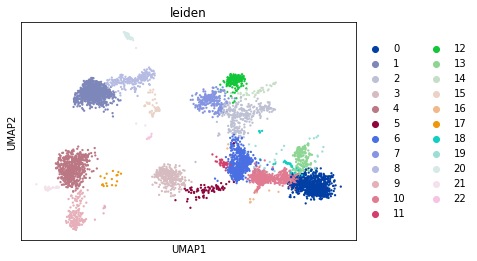

Trying to set attribute `._uns` of view, copying.


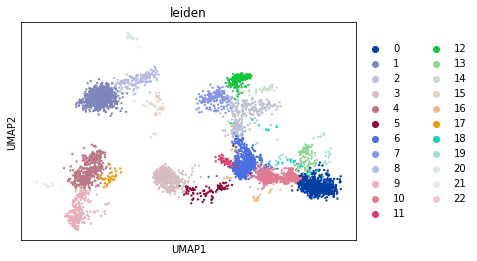

Trying to set attribute `._uns` of view, copying.


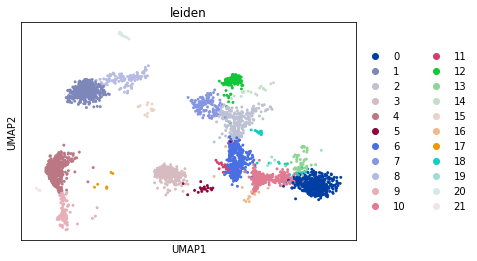

Trying to set attribute `._uns` of view, copying.


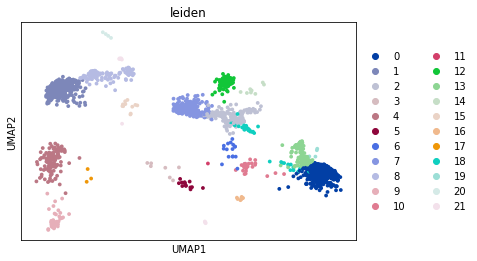

Trying to set attribute `._uns` of view, copying.


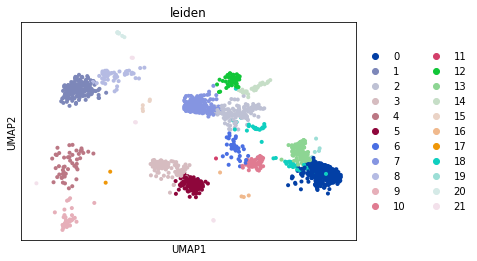

Trying to set attribute `._uns` of view, copying.


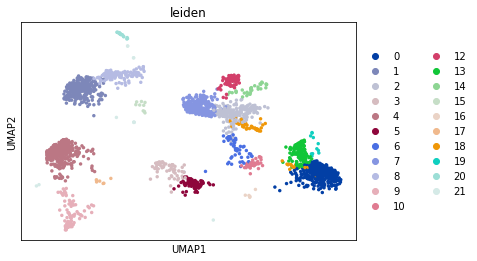

Trying to set attribute `._uns` of view, copying.


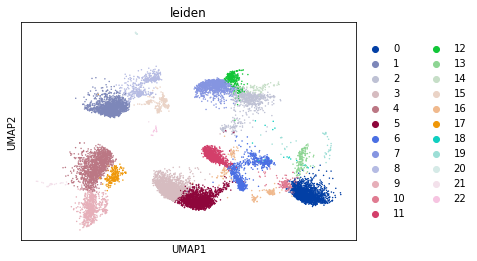

Trying to set attribute `._uns` of view, copying.


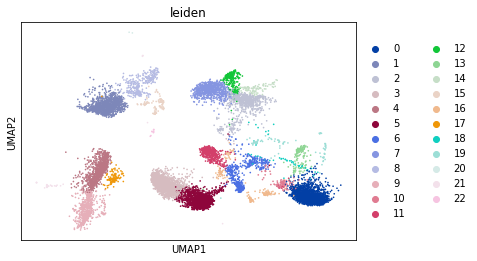

Trying to set attribute `._uns` of view, copying.


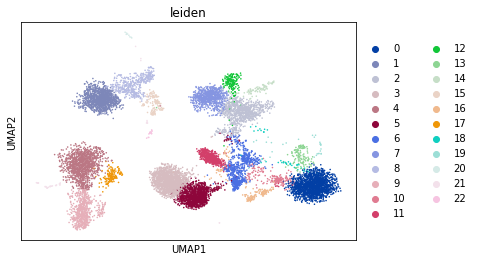

In [35]:
sc.pl.umap(adata, color=['Folder'])

for my_folder in adata.obs.Folder.unique():
    sc.pl.umap(adata[adata.obs.Folder==my_folder], color=['leiden'])

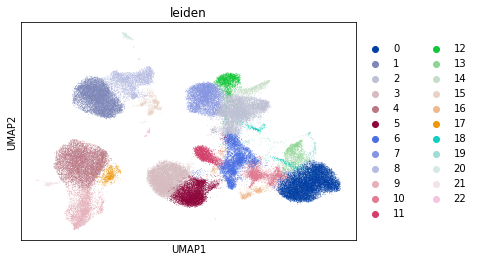

In [36]:
sc.pl.umap(adata, color=['leiden']) #scatter plot coloured by gene

In [37]:
adata.obs.columns

Index(['Folder', 'barcode', 'batch', 'n_genes', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'],
      dtype='object')

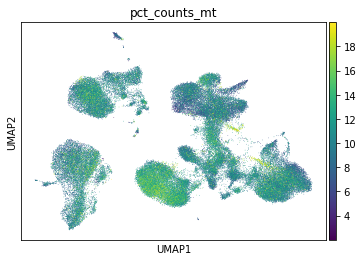

In [38]:
sc.pl.umap(adata, color=['pct_counts_mt'])

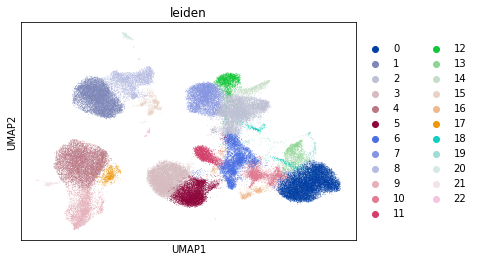

In [39]:
sc.pl.umap(adata, color=['leiden'])

In [40]:
adata.write(results_file)

### FInding Marker Genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

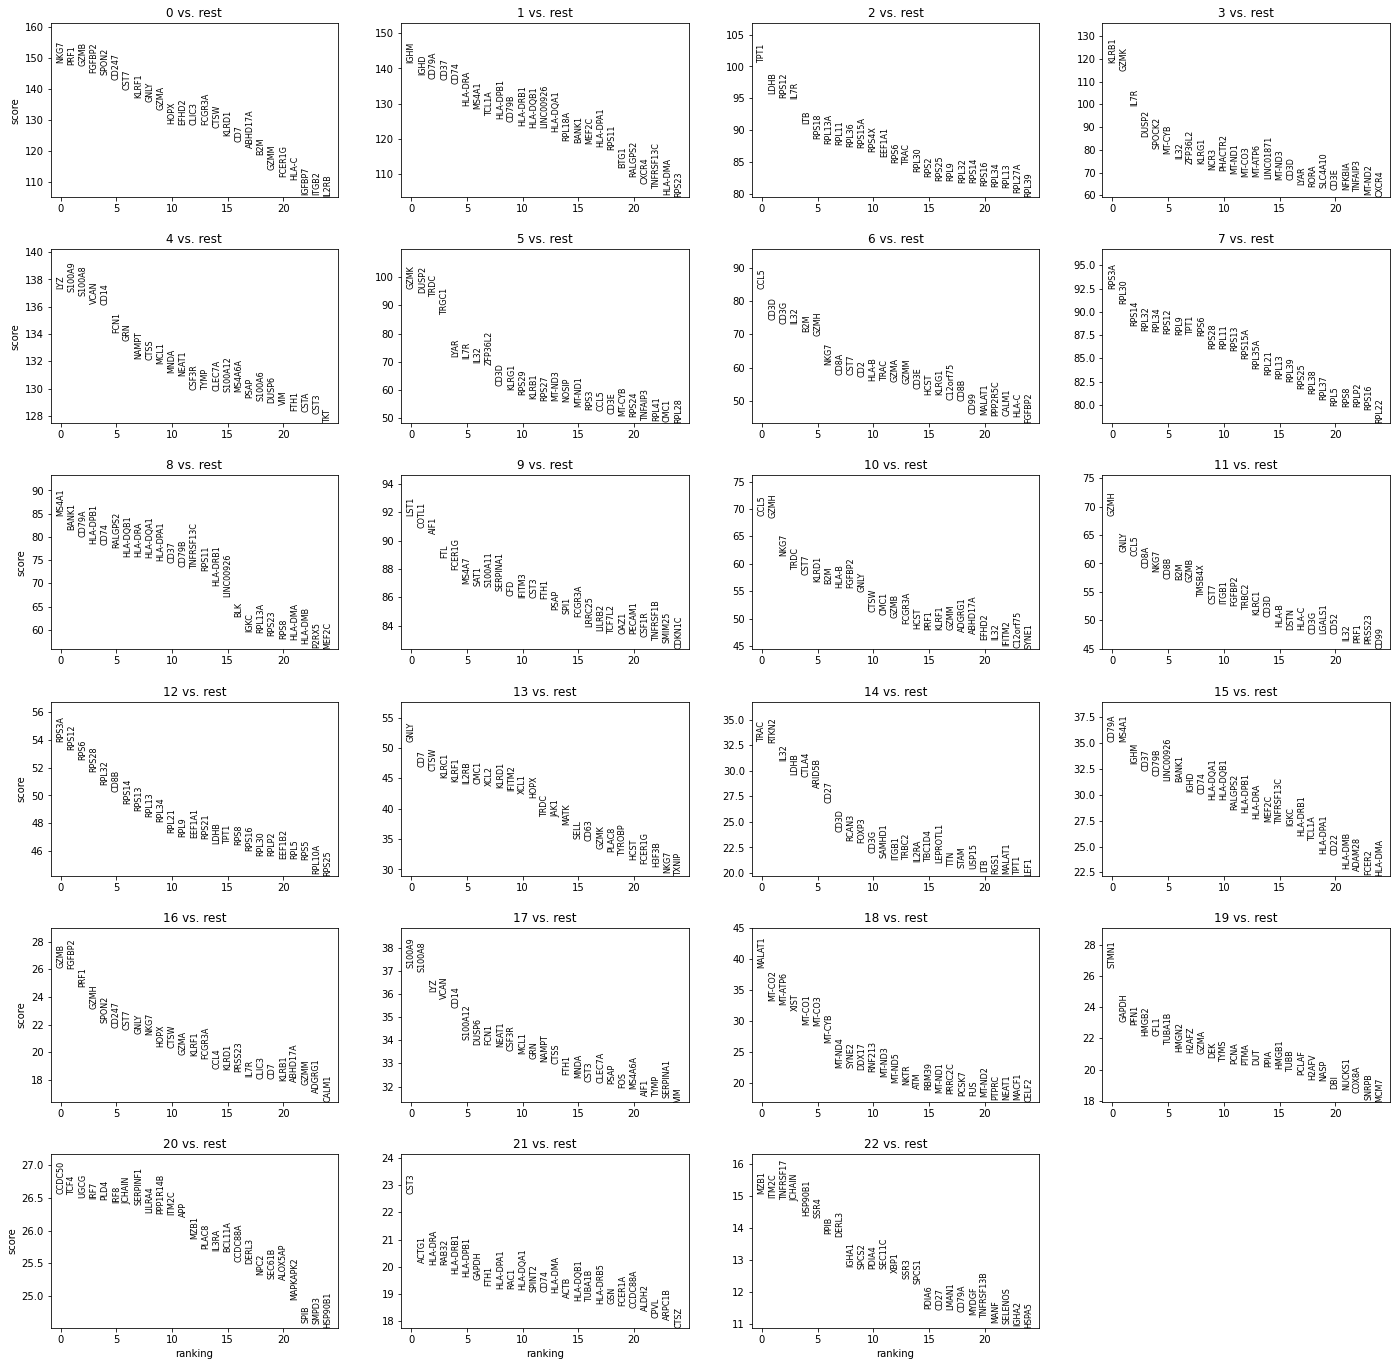

In [41]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', inplace=True)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [42]:
adata.write('results_file')

#### Let us also define a list of marker genes for later reference

In [43]:
marker_genes = ['COTL1', 'GZMK', 'CD4',
                'TRDC','TRGC1','TRGC2','IGHM',
                'IGHD','TRAC','LDHB',
                'CD79A', 'MS4A1', 'CD8A', 
                'CD8B', 'LYZ', 'CD14','LGALS3',
                'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7']

#### Show the 5 top ranked genes per cluster in a dataframe

In [44]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,NKG7,IGHM,TPT1,KLRB1,LYZ,GZMK,CCL5,RPS3A,MS4A1,LST1,...,GNLY,TRAC,CD79A,GZMB,S100A9,MALAT1,STMN1,CCDC50,CST3,MZB1
1,PRF1,IGHD,LDHB,GZMK,S100A9,DUSP2,CD3D,RPL30,BANK1,COTL1,...,CD7,RTKN2,MS4A1,FGFBP2,S100A8,MT-CO2,GAPDH,TCF4,ACTG1,ITM2C
2,GZMB,CD79A,RPS12,IL7R,S100A8,TRDC,CD3G,RPS14,CD79A,AIF1,...,CTSW,IL32,IGHM,PRF1,LYZ,MT-ATP6,PFN1,UGCG,HLA-DRA,TNFRSF17
3,FGFBP2,CD37,IL7R,DUSP2,VCAN,TRGC1,IL32,RPL32,HLA-DPB1,FTL,...,KLRC1,LDHB,CD37,GZMH,VCAN,XIST,HMGB2,IRF7,RAB32,JCHAIN
4,SPON2,CD74,LTB,SPOCK2,CD14,LYAR,B2M,RPL34,CD74,FCER1G,...,KLRF1,CTLA4,CD79B,SPON2,CD14,MT-CO1,CFL1,PLD4,HLA-DRB1,HSP90B1


In [45]:
g = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)
g.to_excel("top_10_genes_per_cluster.xlsx") 

#### Get a table with the scores and groups

In [46]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,18_n,18_p,19_n,19_p,20_n,20_p,21_n,21_p,22_n,22_p
0,NKG7,0.0,IGHM,0.0,TPT1,0.0,KLRB1,0.0,LYZ,0.0,...,MALAT1,0.000000e+00,STMN1,6.751194e-155,CCDC50,1.947653e-155,CST3,7.830125e-114,MZB1,3.058349e-51
1,PRF1,0.0,IGHD,0.0,LDHB,0.0,GZMK,0.0,S100A9,0.0,...,MT-CO2,2.526370e-242,GAPDH,2.350884e-117,TCF4,3.391957e-155,ACTG1,2.493783e-90,ITM2C,1.997587e-50
2,GZMB,0.0,CD79A,0.0,RPS12,0.0,IL7R,0.0,S100A8,0.0,...,MT-ATP6,6.245008e-235,PFN1,8.276998e-116,UGCG,8.771496e-155,HLA-DRA,1.277909e-89,TNFRSF17,5.197735e-50
3,FGFBP2,0.0,CD37,0.0,IL7R,0.0,DUSP2,0.0,VCAN,0.0,...,XIST,1.112852e-220,HMGB2,9.833064e-109,IRF7,1.289183e-154,RAB32,1.689218e-89,JCHAIN,7.431416e-50
4,SPON2,0.0,CD74,0.0,LTB,0.0,SPOCK2,0.0,CD14,0.0,...,MT-CO1,2.292250e-190,CFL1,1.394343e-108,PLD4,2.204773e-154,HLA-DRB1,7.379812e-87,HSP90B1,8.535998e-47


#### Compare single clusters

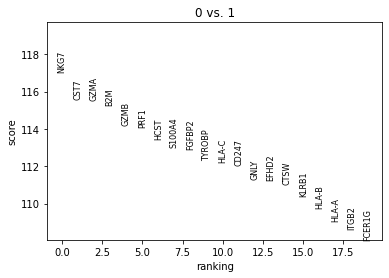

In [47]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

#### Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups)

In [48]:
adata = sc.read(results_file)

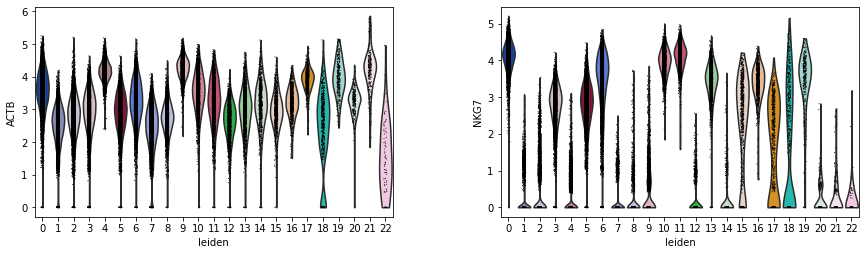

In [49]:
sc.pl.violin(adata, ['ACTB', 'NKG7'], groupby='leiden')

### Marking the Cell Types

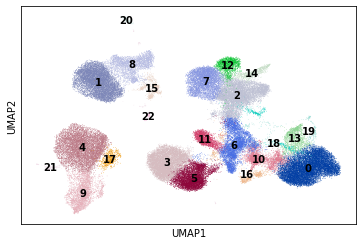

In [50]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=True, save='.pdf')

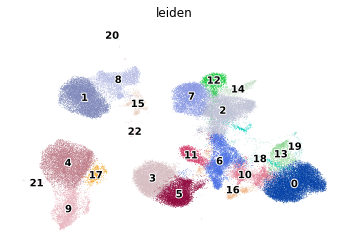

In [51]:
sc.pl.umap(adata, color=['leiden'], legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

In [52]:
#adata.obs['Folder'].value_counts()

In [53]:
adata.write('results_file')

In [54]:
new_cluster_names = ['NK', 'Naive-B', 'Naive T', 'MAIT', 'CD14+ Monocytes', 'GD',
                    'T-Cells', 'Multilymphoid progenitor1', 'Memory-B', 'CD16+ Monocytes', 
                    'Effector CD8+ memory T', 'Cytotoxic T', 'Multilymphoid progenitor2', 
                    'NK-Like1', 'T-Regs', 'B-3', 'NK-Like2', 'Neutrophils',
                    'NK-Like3', 'NK-Like4', 'Plasmacytoid dendritic1', 'Dendritic', 'Plasmacytoid dendritic2']
adata.rename_categories('leiden', new_cluster_names)

In [55]:
sc.set_figure_params(figsize=(8, 6))

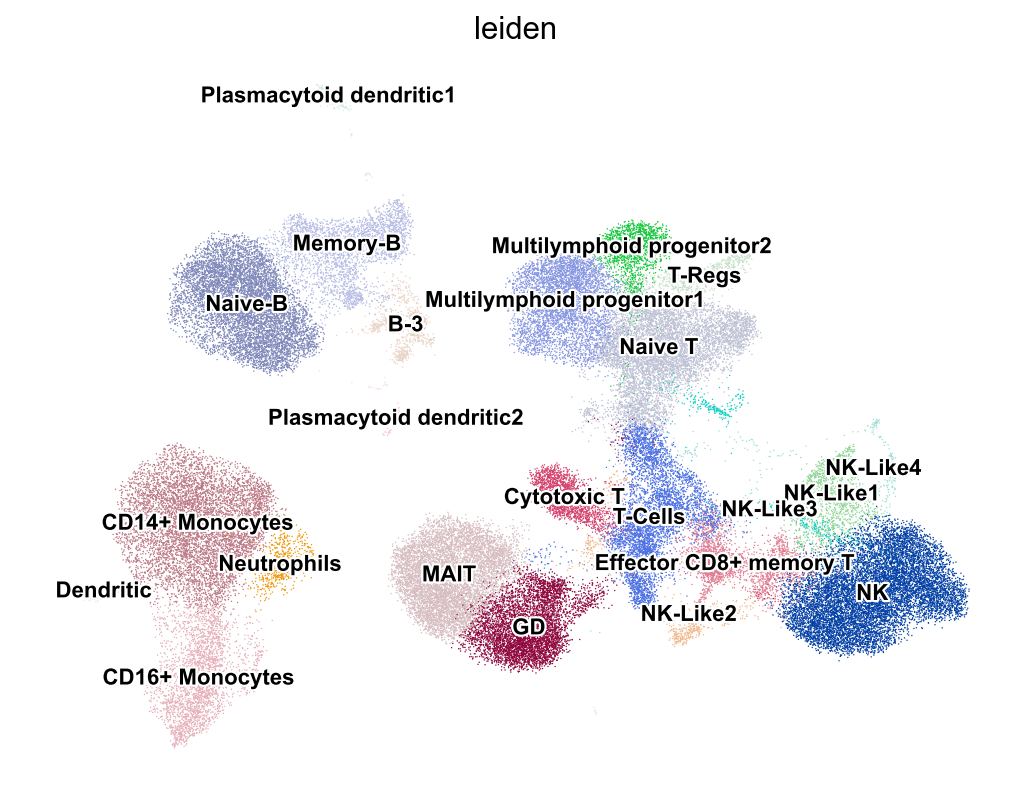

In [61]:
sc.pl.umap(adata, color=['leiden'], projection='2d', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

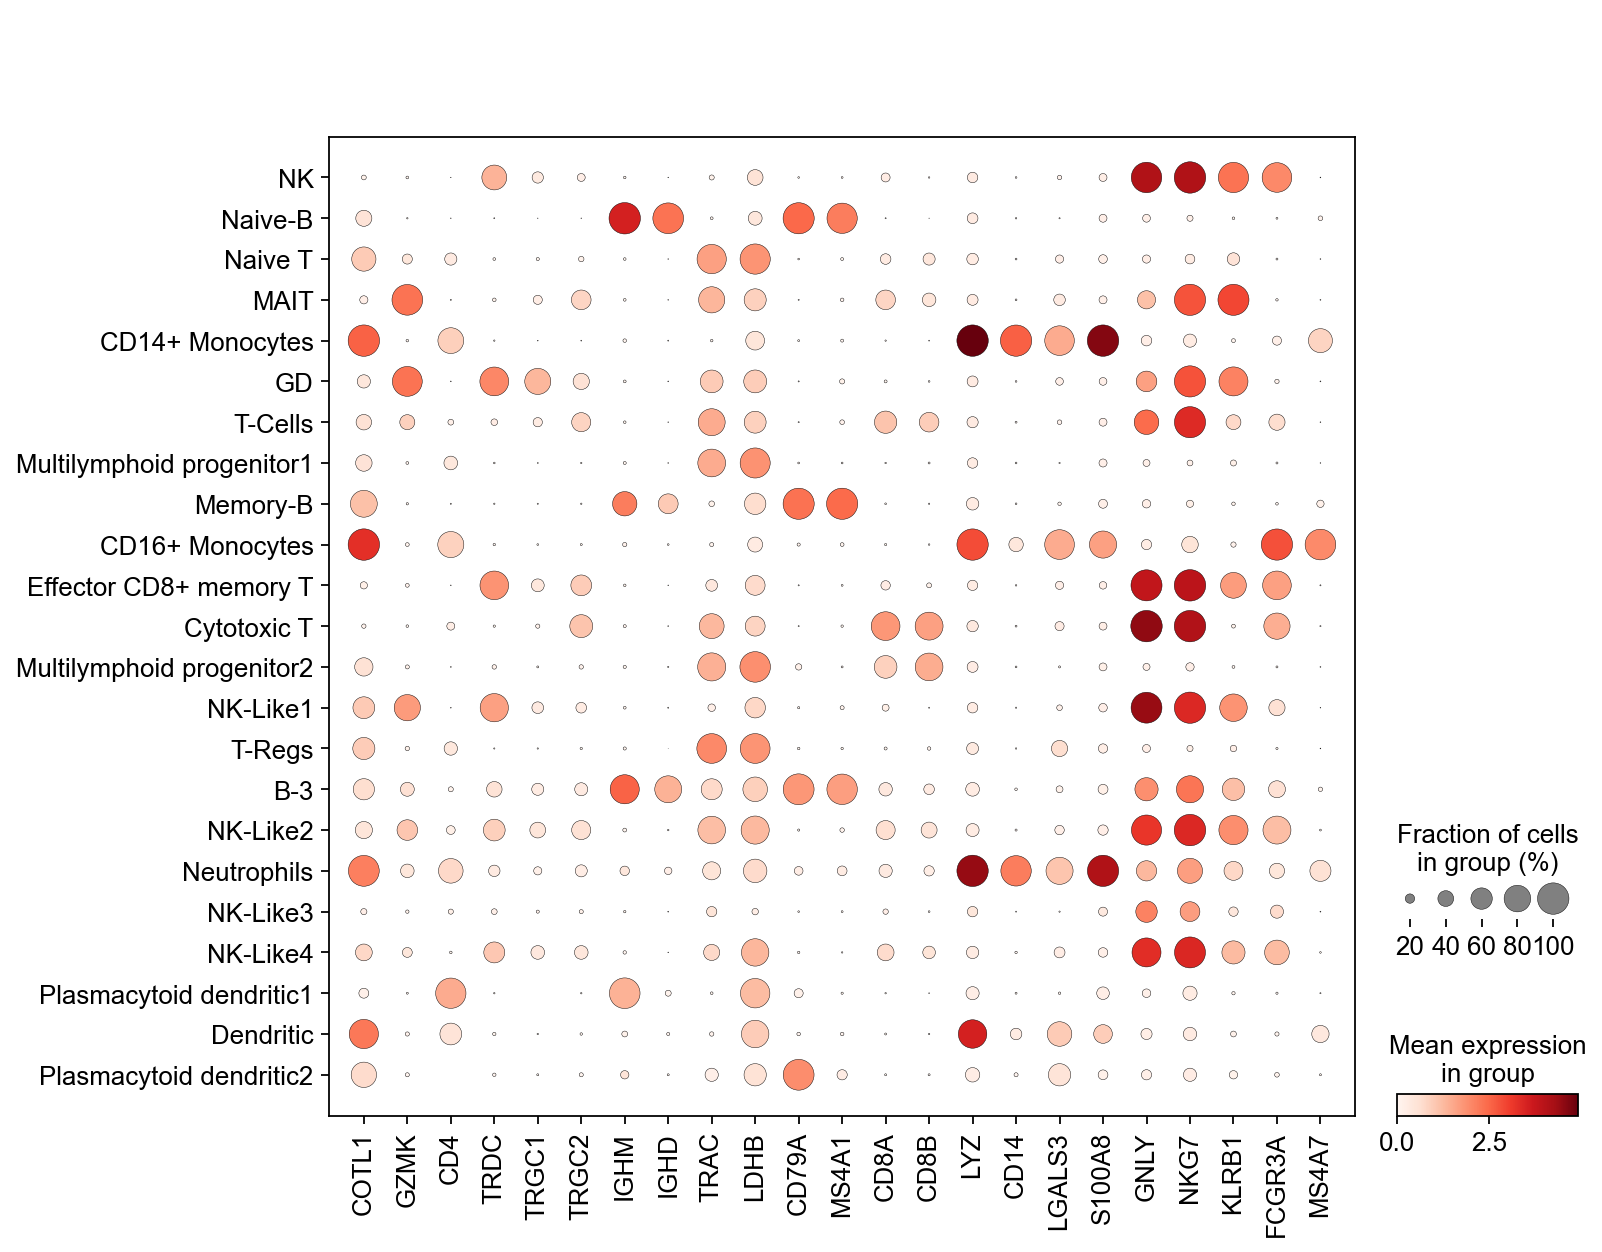

In [57]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

 How many cells are present (according to my clustering) 

In [58]:
adata.obs.leiden.value_counts()

NK                           10904
Naive-B                       7855
Naive T                       7538
MAIT                          7375
CD14+ Monocytes               7054
GD                            5443
T-Cells                       5197
Multilymphoid progenitor1     4749
Memory-B                      3070
CD16+ Monocytes               2968
Effector CD8+ memory T        2620
Cytotoxic T                   1939
Multilymphoid progenitor2     1657
NK-Like1                      1385
T-Regs                         796
B-3                            788
NK-Like2                       765
Neutrophils                    622
NK-Like3                       545
NK-Like4                       304
Plasmacytoid dendritic1        237
Dendritic                      235
Plasmacytoid dendritic2         76
Name: leiden, dtype: int64

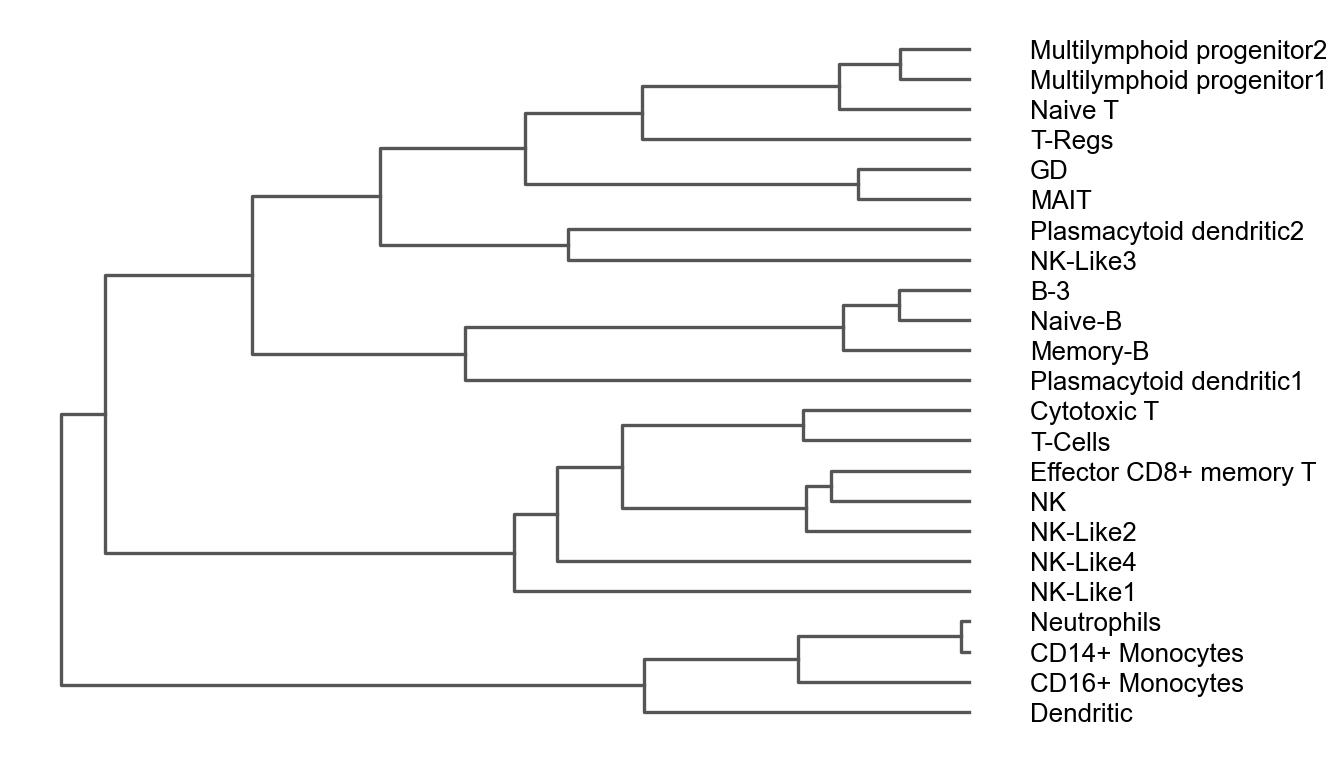

<AxesSubplot:>

In [59]:
sc.tl.dendrogram(adata, 'leiden')
sc.pl.dendrogram(adata, 'leiden', orientation='left')

In [60]:
adata.write(results_file)

### Additional Changes

Cluster 4 changed from a dendritic to CD14+ Monocyte due to high levels of CD14. not sure if correct.

Cluster 1 changed from memory b to naive b cells.

Cluster 8 from B-2 to Memory-B, I'm not sure if this is correct

Cluster 3 changed to MAIT cells.

Cluster 17 to neutrophils.